In [484]:
dex = -1

46464.0
POLYGON ((-97.99999999999999 217, -83.15075759508251 231.8492424049175, -98.00000000000001 246.698484809835, -112.8492424049175 231.8492424049175, -97.99999999999999 217))
......
(-97.99999999999999, 217.0), (-83.15075759508251, 231.8492424049175), (-98.00000000000001, 246.698484809835), (-112.84924240491749, 231.8492424049175), 


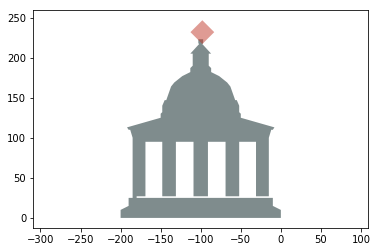

In [526]:
import numpy as np
import time
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import random
from shapely import affinity
import matplotlib.pyplot as plt
from scipy import optimize
from viewer import *
from math import acos
class Room():
    def __init__(self, shape):
        self.shape = shape
        self.polygon = Polygon(np.array(shape, dtype=np.float64))

class FurnitureItem():
    def __init__(self, unitcost, shape):
        self.shape = shape
        self.unit_cost = unitcost
        self.polygon = Polygon(np.array(shape, dtype=np.float64))
        self.total_cost = np.float64((np.float64(self.unit_cost) * self.polygon.area))
        self.sorting = (self.polygon, self.polygon.area)

class Problem():
    def __init__(self, room, furniture):
        self.room = room
        self.furniture = furniture

problems = []
with open('problems.rfp') as f:
    for line in f:
        furnitureList = []
        problem = line.replace(" ","").split("#")

        room_shape = problem[0].split(":")[1]
        furniture = problem[1].split(";")

        room = Room([tuple(np.float64(i) for i in el.strip('()').split(',')) for el in room_shape.split('),(')])

        for furnitureItem in furniture:
            parse_furniture = furnitureItem.strip().split(":")
            unit_cost = parse_furniture[0]
            shape = [tuple(np.float64(i) for i in el.strip('()').split(',')) for el in parse_furniture[1].split('),(')]
            furnitureItem = FurnitureItem(unit_cost, shape)
            furnitureList.append(furnitureItem)
        problems.append(Problem(room,furnitureList))

import numpy.linalg as la

def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points

def newPlot(room, poly):
    x, y = poly.exterior.xy
    x2, y2 = room.exterior.xy
    plt.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.plot(x2, y2, color='#ff0000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.show()
    time.sleep(3)

def insertRandomShape(room,  shape):
    room_coordinates = list(zip(*room.exterior.xy))
    random_vertex = random.randint(0, len(room_coordinates) - 1)
    room_vertex = room_coordinates[random_vertex]
    shape_coordinates = list(zip(*shape.exterior.xy))

    room_coordinate_x = room_vertex[0]
    room_coordinate_y = room_vertex[1]

    def f(angle):
        return affinity.rotate(shape, angle, origin=(room_coordinate_x, room_coordinate_y)).difference(room).area

    for shape_coordinate_x, shape_coordinate_y in shape_coordinates:
        new_translated_shape = affinity.translate(shape, room_coordinate_x - shape_coordinate_x, room_coordinate_y - shape_coordinate_y)
        angle = np.float64(360) + optimize.minimize_scalar(f, bounds=(0,360), method='golden', options={'xtol': 1e-15}).x
        new_rotated_shape = affinity.rotate(new_translated_shape, angle, origin=(room_coordinate_x, room_coordinate_y))

        if (room.difference(new_rotated_shape).area == room.area - new_rotated_shape.area):
            new_updatable_room = Polygon()
            room_to_check = room.difference(new_rotated_shape)
            if (room_to_check.geom_type == 'MultiPolygon'):
                for poly in room_to_check:
                    new_updatable_room.union(poly)
            else:
                new_updatable_room = room_to_check

            if new_updatable_room.area > 0.00000000000000000000001:
                return (True, new_updatable_room, new_rotated_shape)
            else:
                continue
    return (False, room, shape)

def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points



def get_sorted_shapes(furniture_list):
    sorted_shapes = []
    for shape in furniture_list:
        sorted_shapes.append((shape, shape.total_cost, shape.polygon.area))

    sorted_shapes = sorted(sorted_shapes, key = lambda x:x[1], reverse=True)
    return sorted_shapes

def get_output(solution):
    output = ""
    for x in solution:
        output = output + str(x[:-1]).replace('[','').replace(']','') + "; "
    return output

def get_cost(solution_shapes):
    total_cost = 0
    for shape in solution_shapes:
        total_cost = total_cost + shape.total_cost
    return total_cost


def get_angle(a,b):
    angle = np.arctan2(b[1], b[0]) - np.arctan2(a[1],a[0])
    return angle


# TODO: vertice number insetead of coordinates
def autofit_shape(room, shape, room_vertice_index, shape_vertice_index):

    room_vertice_index = room_vertice_index
    shape_vertice_index = shape_vertice_index

    room_coords = list(zip(*(room.exterior.xy)))
    shape_coords = list(zip(*(shape.exterior.xy)))

    trans_x, trans_y = room_coords[room_vertice_index]

    new_shape = affinity.translate(shape, trans_x, trans_y)
    new_shape_coordinates = list(zip(*(new_shape.exterior.xy)))

    shape_vector1 = np.array(new_shape_coordinates[shape_vertice_index+1])-np.array(new_shape_coordinates[shape_vertice_index])
    room_vector1 = np.array(room_coords[(room_vertice_index+1)])-np.array(room_coords[room_vertice_index])

    angle_to_rotate = get_angle(shape_vector1, room_vector1)
    new_rotated_shape = affinity.rotate(new_shape, angle_to_rotate, origin=Point(trans_x, trans_y), use_radians=True)

    if (room.difference(new_rotated_shape).area == room.area - new_rotated_shape.area):
        new_updatable_room = Polygon()
        room_to_check = room.difference(new_rotated_shape)
        if (room_to_check.geom_type == 'MultiPolygon'):
            for poly in room_to_check:
                new_updatable_room.union(poly)
        else:
            new_updatable_room = room_to_check

        if new_updatable_room.area > 0.00000000000000000000001:
            return (True, new_updatable_room, new_rotated_shape)

    return (False, room, new_rotated_shape)

def algorithm(problem):
    room_polygon = problem.room.polygon
    updatable_room = room_polygon
    shapes = problem.furniture
    solution_translated_shapes = []

    solution = []
    solution_shapes = []

    sorted_shapes = []
    for shape in shapes:
        sorted_shapes.append((shape, shape.total_cost))

    sorted_shapes = sorted(sorted_shapes, key = lambda x:x[1], reverse=True)

    for i in range(10):
        for shape, d in sorted_shapes:
            points = random_points_within(updatable_room, 1)[0]
            polygon = affinity.translate(shape.polygon, points.x, points.y)
            polygon = affinity.rotate(polygon, random.uniform(0, 180), origin="centroid")
            if updatable_room.contains(polygon):
                updatable_room = updatable_room.difference(polygon)
                x, y = polygon.exterior.xy
                solution_shapes.append(shape)
                solution.append(list(zip(*(x, y))))
                solution_translated_shapes.append(polygon)
                sorted_shapes.remove((shape, d))
                print(1 - updatable_room.area / problem.room.polygon.area)

    print("Area coverage: " + str(1 - (updatable_room.area / problem.room.polygon.area)))
    return (solution, solution_shapes, solution_translated_shapes)

def get_specific_shape(shape):
    output = ""
    for x, y in list(zip(*(shape.exterior.xy)))[:-1]:
        output = output +  "(" + str(x) + ", " + str(y) + ")" + ", "
    return output

i = 30
dex = dex +1
test_shape = get_sorted_shapes(problems[i-1].furniture)
sorted_shapes = get_sorted_shapes(problems[i-1].furniture)
new_test_shape = autofit_shape(problems[i-1].room.polygon, sorted_shapes[7][0].polygon,dex,0)

draw_room(problems[i-1].room.polygon)
draw_shape(new_test_shape[2])

print(sorted_shapes[0][1])
print(new_test_shape[2])
print('......')
print(get_specific_shape(new_test_shape[2]))
plt.axis('equal')
plt.show()

In [ ]:
(-10.0, 25.0), (-32.0, 25.0), (-32.0, 3.0), (-10.0, 3.0),
(-169.0, 95.0), (-147.0, 95.0), (-147.0, 117.0), (-169.0, 117.0),
(-131.0, 95.0), (-109.0, 95.0), (-109.0, 117.0), (-131.0, 117.0),
(-91.0, 95.0), (-70.0, 95.0), (-70.0, 116.0), (-91.0, 116.0),
(-52.0, 95.0), (-31.0, 95.0), (-31.0, 116.0), (-52.0, 116.0),
(-50.00000000000001, 130.0), (-64.8492424049175, 144.8492424049175), (-79.69848480983501, 130.0), (-64.8492424049175, 115.1507575950825),
